In [1]:
# Lots of headers, though some may be unused rn
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from keras.preprocessing import image
import numpy as np
from keras.utils import np_utils
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from moviepy.editor import VideoFileClip

Using TensorFlow backend.


Part 1: Partition the video into frames and save within a temp folder.

In [0]:
# Uses google colab for this, you may have to use your own.
from google.colab import drive
drive.mount('/content/drive')

In [4]:
cd drive/'My Drive'/'DLP Program'

/content/drive/My Drive/DLP Program


In [5]:
ls

 drumming1.MP4         drumming2_Predictions.png   random.MP4
 drumming2_data.json   erratic1.MP4               'Sample Outputs'/
 drumming2.MP4         pockets1.MP4                temp/


In [0]:
videoFile = "erratic1.MP4"
# The input function doesn't seem to work on colab, manually editing the file name for now.
# input(videoFile)

In [0]:
# Breaks the video by frames for training set
cap = cv2.VideoCapture(videoFile)
x=1; count = 0
while(cap.isOpened()):
    # Current frame number
    frameId = cap.get(1)
    ret, frame = cap.read()
    if (ret != True):
        break
    # Saves every 10th frame in the video, can be changed 
    if (frameId % 10 == 0): 
        filename ='temp/' + videoFile.split(' ')[0] +"_frame%d.jpg" % count;
        count+=1
        cv2.imwrite(filename, frame)
cap.release()

Part 2: Prepare the model we chose, this is what ours will look like for now

In [0]:
# Uses the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

# Defining the architecture 
model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [0]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

Part 3: Begin analyzing the frames!

In [0]:
# creating two lists to store predicted and actual tags
predict = []

images = glob("temp/*.jpg")
prediction_images = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    prediction_images.append(img)
prediction_images = np.array(prediction_images)
prediction_images = base_model.predict(prediction_images)
prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
prediction = model.predict(prediction_images)

In [0]:
# Get timestamps
clip = VideoFileClip(videoFile)
timestamps = np.arange(0.0, clip.duration, clip.duration/(len(prediction)))

# Get prediction values here
prediction = prediction.transpose()
drumming = prediction[0]
erratic = prediction[1]
pockets = prediction[2]

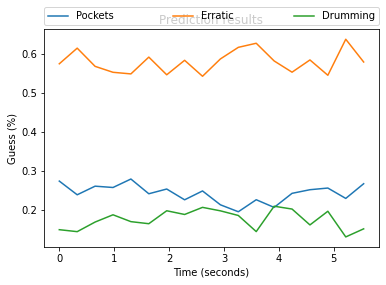

In [30]:
# Plot here!
plt.title('Prediction results')
plt.xlabel('Time (seconds)')
plt.ylabel('Guess (%)')

plt.plot(timestamps, pockets, label="Pockets")
plt.plot(timestamps, erratic, label="Erratic")
plt.plot(timestamps, drumming, label="Drumming")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

plt.savefig(videoFile.split('.')[0] + '_Predictions.png')

In [23]:
# Creates the json here!
import json
data1 = list(zip(timestamps, pockets))
data2 = list(zip(timestamps, erratic))
data3 = list(zip(timestamps, drumming))

data1 = [list([float(i) for i in ele]) for ele in data1] 
data2 = [list([float(i) for i in ele]) for ele in data2] 
data3 = [list([float(i) for i in ele]) for ele in data3]

print(data1)
dicttemp = {'pockets':data1,'erratic':data2,'drumming':data3}
with open(videoFile.split('.')[0] + '_data.json', 'w') as f:
    json.dump(dicttemp, f)

[[0.0, 0.2564212679862976], [0.3334782608695652, 0.2838439643383026], [0.6669565217391304, 0.3047052025794983], [1.0004347826086957, 0.31541672348976135], [1.333913043478261, 0.3150182068347931], [1.6673913043478261, 0.32184597849845886], [2.0008695652173913, 0.33722564578056335], [2.3343478260869563, 0.33138227462768555], [2.667826086956522, 0.2971910536289215], [3.0013043478260872, 0.29354408383369446], [3.3347826086956522, 0.28679826855659485], [3.6682608695652172, 0.2863197922706604], [4.001739130434783, 0.30835846066474915], [4.335217391304348, 0.3294018805027008], [4.668695652173913, 0.33982568979263306], [5.002173913043478, 0.3675239384174347], [5.335652173913044, 0.3511956036090851], [5.669130434782609, 0.3304419219493866], [6.0026086956521745, 0.3297715485095978], [6.336086956521739, 0.35286182165145874], [6.6695652173913045, 0.35682687163352966], [7.00304347826087, 0.33076363801956177], [7.3365217391304345, 0.33804526925086975]]
